In [1]:
import os 
import pandas as pd
import pyarrow 
import numpy as np
import seaborn  as sns 
import matplotlib.pyplot as plt

In [2]:
green_sample_path="../data/green_tripdata_2022.parquet"
yellow_sample_path="../data/yellow_tripdata_2022.parquet"
df_green = pd.read_parquet(green_sample_path)
df_yellow = pd.read_parquet(yellow_sample_path)


In [ ]:
df_green.shape, df_yellow.shape

In [ ]:
#check missing values
print(df_green.isnull().sum())


In [ ]:
print(df_yellow.isnull().sum())

In [ ]:
#get 10000 sample from green 
df_green=df_green.sample(n=10000, random_state=1)


In [ ]:
#drop missing values
df_green=df_green.dropna()
df_yellow=df_yellow.dropna()

In [ ]:
print(df_green.shape)
df_green.head()


In [ ]:
print(df_yellow.shape)
df_yellow.head()

In [3]:
green_cols = df_green.columns
yellow_cols = df_yellow.columns
#find the common columns
common_cols = set(green_cols).intersection(set(yellow_cols))
print(common_cols)
print(len(common_cols))
diff_green_cols = set(green_cols).difference(set(yellow_cols))
diff_yellow_cols = set(yellow_cols).difference(set(green_cols))
print(diff_green_cols)
print(diff_yellow_cols)


{'trip_distance', 'mta_tax', 'DOLocationID', 'extra', 'PULocationID', 'tip_amount', 'improvement_surcharge', 'congestion_surcharge', 'tolls_amount', 'store_and_fwd_flag', 'passenger_count', 'total_amount', 'VendorID', 'RatecodeID', 'payment_type', 'fare_amount'}
16
{'ehail_fee', 'trip_type', 'lpep_dropoff_datetime', 'lpep_pickup_datetime'}
{'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'airport_fee'}


In [4]:
#renname lpep_pickup_datetime to pickup_datetime
df_green = df_green.rename(columns={"lpep_pickup_datetime":"pickup_datetime"})
df_yellow = df_yellow.rename(columns={"tpep_pickup_datetime":"pickup_datetime"})
#rename lpep_dropoff_datetime to dropoff_datetime
df_green = df_green.rename(columns={"lpep_dropoff_datetime":"dropoff_datetime"})
df_yellow = df_yellow.rename(columns={"tpep_dropoff_datetime":"dropoff_datetime"})
#rename 
#convert type to string
df_green['pickup_datetime'] = df_green['pickup_datetime'].astype(str)
df_green['dropoff_datetime'] = df_green['dropoff_datetime'].astype(str)

In [10]:
#collapse

# help function
def basic_feature_extract(df):
    df_= df.copy()
    # pickup
    df_["pickup_date"] = pd.to_datetime(df_.pickup_datetime.apply(lambda x : x.split(" ")[0]))
    df_["pickup_hour"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["pickup_year"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["pickup_month"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["pickup_weekday"] = df_.pickup_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    # dropoff
    # in case test data dont have dropoff_datetime feature
    try:
        df_["dropoff_date"] = pd.to_datetime(df_.dropoff_datetime.apply(lambda x : x.split(" ")[0]))
        df_["dropoff_hour"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
        df_["dropoff_year"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
        df_["dropoff_month"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
        df_["dropoff_weekday"] = df_.dropoff_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    except:
        pass 
    return df_

# get weekday
import calendar


def get_weekday(df):
    list(calendar.day_name)
    df_=df.copy()
    df_['pickup_week_'] = pd.to_datetime(df_.pickup_datetime).dt.weekday
    df_['pickup_weekday_'] = df_['pickup_week_'].apply(lambda x: calendar.day_name[x])
    return df_

# get trip duration 
def get_duration(df):
    df_= df.copy()
    df_['trip_duration_cal'] = pd.to_datetime(df_['dropoff_datetime']) - pd.to_datetime(df_['pickup_datetime'])
    return df_



In [7]:
df_green=basic_feature_extract(df_green)

In [ ]:
df_green["pickup_week_"]

In [11]:
df_green=get_duration(df_green)
df_green=get_weekday(df_green)

In [8]:
df_green.head()

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,pickup_date,pickup_hour,pickup_year,pickup_month,pickup_weekday,dropoff_date,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,...,2022-01-01,00,2022,01,5,2022-01-01,00,2022,01,5
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,...,2022-01-01,00,2022,01,5,2022-01-01,00,2022,01,5
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,...,2022-01-01,00,2022,01,5,2022-01-01,01,2022,01,5
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,...,2022-01-01,00,2022,01,5,2022-01-01,00,2022,01,5
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,...,2022-01-01,00,2022,01,5,2022-01-01,00,2022,01,5


In [ ]:
df_yellow = basic_feature_extract(df_yellow)

In [ ]:
#check type pick up and drop off
print(df_green['pickup_datetime'].dtype)


In [ ]:
df_green

In [ ]:
print(df_green.describe())


In [ ]:
df_green.groupby('pickup_datetime').count()['VendorID'].plot()

In [13]:
#create unique id
df_green['id']=df_green.index

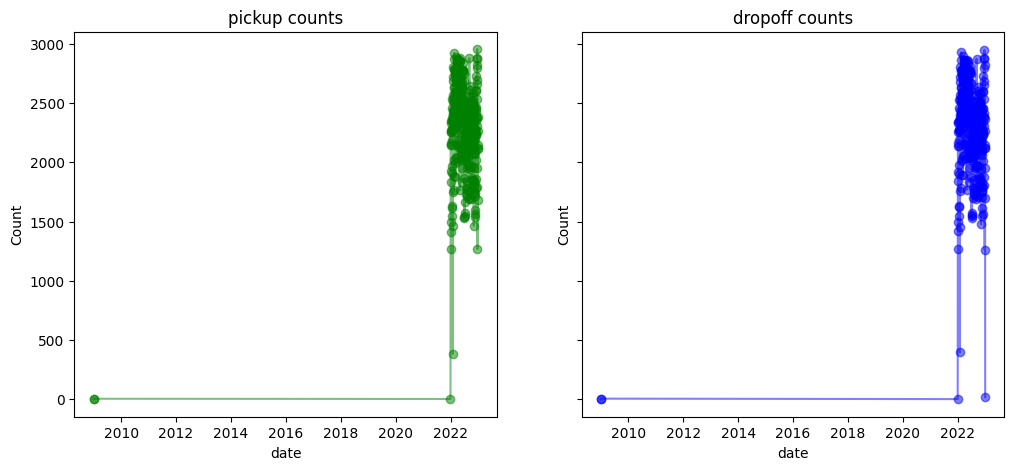

In [14]:
#collapse
fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(12, 5)

ax[0].plot(df_green.groupby('pickup_date')["id"].count(), 'go-', alpha=0.5)
ax[1].plot(df_green.groupby('dropoff_date')["id"].count(), 'bo-', alpha=0.5)

ax[0].set(xlabel='date', ylabel='Count',title="pickup counts")
ax[1].set(xlabel='date', ylabel='Count',title="dropoff counts")

plt.show()

In [ ]:
print(df_yellow.describe())